In [7]:
### Imports

In [8]:
from __future__ import print_function,unicode_literals,division
from io import open
import glob
import os
import unicodedata
import string
import torch

In [9]:
def findFiles(path):
    return glob.glob(path)

In [10]:
print(findFiles('data/names/*.txt'))

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


In [11]:
all_letters = string.ascii_letters + ".,;"
n_letters = len(all_letters)

In [12]:
#Turn Unicode to plain ASCII
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) !='Mn'
                  and c in all_letters)

In [13]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [14]:
#Building catgeory_lines dictionary
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [15]:
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [16]:
print(category_lines['Polish'][:5])

['Adamczak', 'Adamczyk', 'Andrysiak', 'Auttenberg', 'Bartosz']


In [17]:
def letterToIndex(letter):
    return all_letters.find(letter)

In [18]:
def letterToTensor(letter):
    tensor = torch.zeros(1,n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

In [19]:
def lineToTensor(line):
    tensor = torch.zeros(len(line),1,n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor    

In [20]:
print (letterToTensor('Z'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0.]])


In [24]:
print(lineToTensor('jones').size())

torch.Size([5, 1, 55])


In [25]:
##Creating the network
import torch.nn as nn

In [26]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self,input,hidden):
        combined = torch.cat((input,hidden),1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output,hidden
    
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)

In [27]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [28]:
input = letterToTensor('A')
hidden = torch.zeros(1,n_hidden)

output, next_hidden = rnn(input,hidden)

In [29]:
input = lineToTensor('Albert')
hidden = torch.zeros(1,n_hidden)

output, next_hidden = rnn(input[0],hidden)
print(output)

tensor([[-2.9527, -2.8156, -2.9542, -2.8837, -2.8985, -2.9099, -3.0032, -2.7881,
         -2.8731, -2.8964, -2.8773, -2.9431, -2.9049, -2.9212, -2.8343, -2.8670,
         -2.8115, -2.9181]], grad_fn=<LogSoftmaxBackward>)


In [30]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('French', 7)


In [35]:
import random

def randomChoice(l):
    return l[random.randint(0,len(l)-1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category,line,category_tensor,line_tensor

for i in range(10):
    cat, line, cat_ten, lin_ten = randomTrainingExample()
    print('category = ',cat, ' line = ',line)

category =  French  line =  Degarmo
category =  Greek  line =  Koulaxizis
category =  Chinese  line =  Xiong
category =  Spanish  line =  Viteri
category =  Italian  line =  Parisi
category =  Portuguese  line =  Barros
category =  Greek  line =  Bilias
category =  Scottish  line =  Black
category =  Portuguese  line =  Rocha
category =  Korean  line =  San


In [37]:
criterion = nn.NLLLoss()

learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, loss.item()

In [38]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

In [41]:
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m,s)

start = time.time()

for iter in range(1,n_iters+1):
    cat, line, cat_ten, line_ten = randomTrainingExample()
    output,loss = train(cat_ten,line_ten)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess==cat else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
    
    if iter % plot_every == 0:
        all_losses.append(current_loss/plot_every)
        current_loss = 0

5000 5% (0m 4s) 0.6011 Antonino / Italian ✓
10000 10% (0m 9s) 1.2394 Dounias / Greek ✓
15000 15% (0m 14s) 0.8521 Wallace / Scottish ✓
20000 20% (0m 19s) 1.0967 Tian / Vietnamese ✗ (Polish)
25000 25% (0m 23s) 0.0115 Davidson / Scottish ✓
30000 30% (0m 28s) 0.2495 OBrien / Irish ✓
35000 35% (0m 32s) 0.3030 Ramaaker / Dutch ✓
40000 40% (0m 37s) 4.4149 Satorie / French ✗ (Polish)
45000 45% (0m 42s) 1.0059 Faucher / French ✓
50000 50% (0m 46s) 1.6574 Elmer / German ✗ (Polish)
55000 55% (0m 51s) 0.2486 You / Korean ✓
60000 60% (0m 55s) 3.0771 Jelen / English ✗ (Polish)
65000 65% (1m 0s) 0.0224 Madaidhin / Irish ✓
70000 70% (1m 4s) 0.6780 Coghlan / Irish ✓
75000 75% (1m 9s) 0.3999 Legrand / French ✓
80000 80% (1m 13s) 0.4547 OBrien / Irish ✓
85000 85% (1m 18s) 0.3272 Ling / Chinese ✓
90000 90% (1m 22s) 0.2865 Schreck / German ✓
95000 95% (1m 27s) 0.6591 Tsogas / Greek ✓
100000 100% (1m 31s) 1.1331 Duncan / Irish ✓


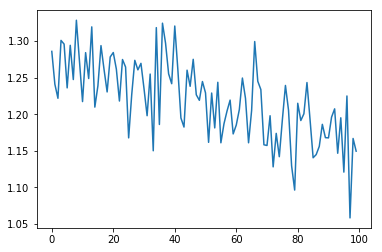

In [45]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
plt.figure()
plt.plot(all_losses)

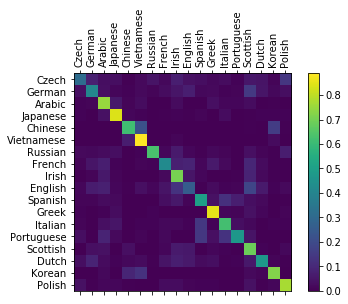

In [46]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()